## Import Packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# read
df = pd.read_csv('../data/5guys_flight_data_preprocessed.csv')
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,TAIL_NUM,ORIGIN,DEST,DEP_DEL15,CRS_ARR_TIME,DISTANCE,CARRIER_NAME,...,PREVIOUS_AIRPORT,AWND,PRCP,TAVG,WDF2,WSF2,WT03,WT08,DEL_ORIGIN_COUNT,WT_FOG
0,1,28,1,182,14,12,1.0,1306,1652.0,15,...,53,12.75,0.53,18.0,300.0,25.9,0.0,1.0,74377.0,1
1,1,28,1,2365,14,3,1.0,1200,888.0,15,...,53,12.75,0.53,18.0,300.0,25.9,0.0,1.0,74377.0,1
2,1,28,1,1481,14,6,1.0,853,925.0,15,...,53,12.75,0.53,18.0,300.0,25.9,0.0,1.0,74377.0,1
3,1,28,1,2401,14,3,0.0,1040,888.0,15,...,53,12.75,0.53,18.0,300.0,25.9,0.0,1.0,74377.0,1
4,1,28,1,2941,14,12,1.0,1435,2072.0,15,...,53,12.75,0.53,18.0,300.0,25.9,0.0,1.0,74377.0,1


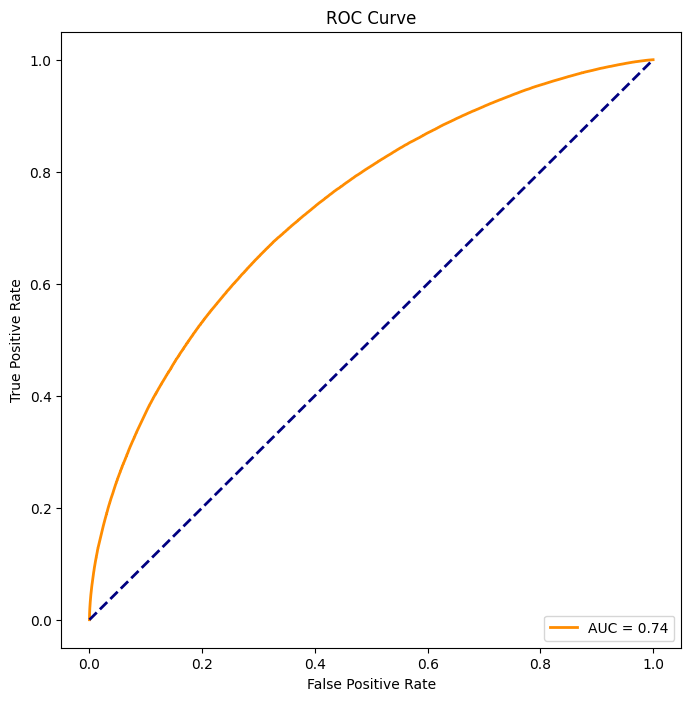

Accuracy: 0.6832908406371971
Confusion Matrix:
[[606773 274048]
 [ 69920 135328]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.69      0.78    880821
         1.0       0.33      0.66      0.44    205248

    accuracy                           0.68   1086069
   macro avg       0.61      0.67      0.61   1086069
weighted avg       0.79      0.68      0.72   1086069



/Users/terlan/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 600x600 with 0 Axes>

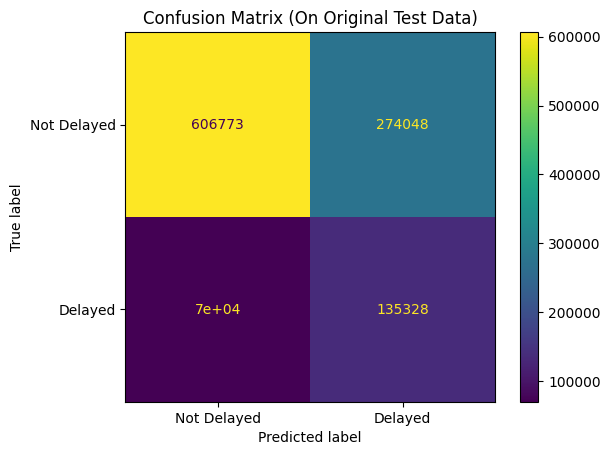

In [4]:
# Select all columns as features except the target column
features = df.columns.tolist()
features.remove('DEP_DEL15')

target = 'DEP_DEL15'  # You can choose another relevant column for binary classification
df = df.dropna(subset=[target])

# Split the dataset into training and testing sets
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform RandomUnderSampler undersampling on the training data only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Create and train an XGBoost classification model on the resampled training data
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the original test set
y_pred = model.predict(X_test)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the original test set
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

# Confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(model, X_test, y_test, display_labels=['Not Delayed', 'Delayed'])
plt.title('Confusion Matrix (On Original Test Data)')
plt.show()


### Balancing with SMOTE and training with XGBoost

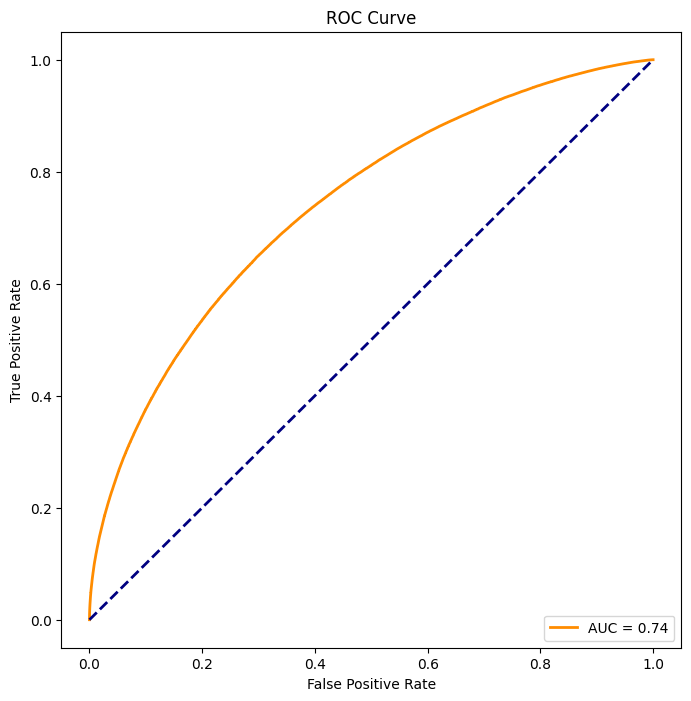

Accuracy: 0.8242791203873787
Confusion Matrix:
[[867733  13088]
 [177757  27491]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.99      0.90    880821
         1.0       0.68      0.13      0.22    205248

    accuracy                           0.82   1086069
   macro avg       0.75      0.56      0.56   1086069
weighted avg       0.80      0.82      0.77   1086069



/Users/terlan/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 600x600 with 0 Axes>

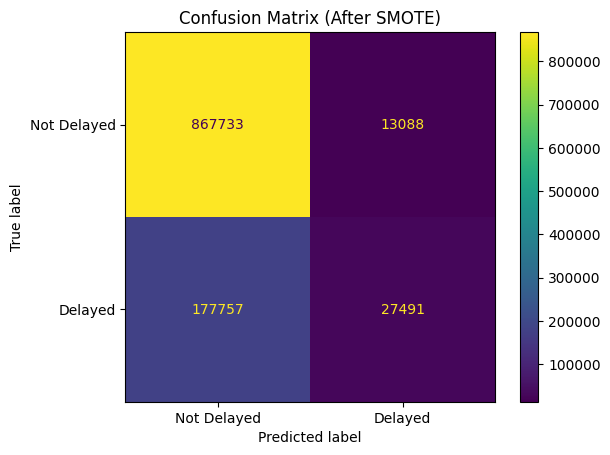

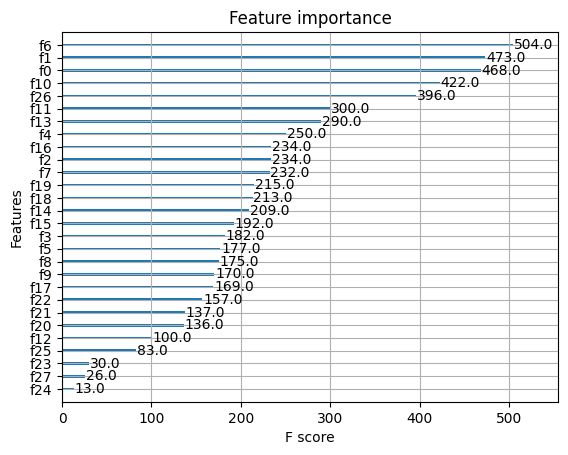

In [12]:
# Select all columns as features except the target column
features = df.columns.tolist()
features.remove('DEP_DEL15')

target = 'DEP_DEL15'  # You can choose another relevant column for binary classification
df = df.dropna(subset=[target])

# Split the dataset into training and testing sets
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform RandomUnderSampler undersampling on the training data only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Create and train an XGBoost classification model
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

model.fit(X_train_resampled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

# Confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(model, X_test, y_test, display_labels=['Not Delayed', 'Delayed'])
plt.title('Confusion Matrix (After SMOTE)')
plt.show()

# Plot the feature importances
xgb.plot_importance(model)
plt.show()
